In [1]:
# add the path to the source code of the MonoForce package
import sys
sys.path.append('../src')

In [2]:
import os
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [4]:
# Training parameters
batch_size = 16
num_epochs = 100
lr = 1e-4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
robot = 'tradr'
small_data = True
vis = True

In [5]:
from monoforce.models.dphysics import DPhysics
from monoforce.dphys_config import DPhysConfig
from monoforce.utils import read_yaml

# load configs: Differentiable Physics
dphys_cfg = DPhysConfig()

# load configs: LSS (Terrain Encoder)
lss_config_path = f'../config/lss_cfg_{robot}.yaml'
assert os.path.isfile(lss_config_path), 'LSS config file %s does not exist' % lss_config_path
lss_cfg = read_yaml(lss_config_path)
pretrained_model_path = f'../config/weights/lss/lss_robingas_{robot}.pt'

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [6]:
# Load Differentiable Physics
dphysics = DPhysics(dphys_cfg, device=device)

In [7]:
from monoforce.models.terrain_encoder.lss import compile_model

# Load LSS (Terrain Encoder)
lss = compile_model(lss_cfg['grid_conf'], lss_cfg['data_aug_conf'], inpC=3, outC=1)
if os.path.exists(pretrained_model_path):
    # load pretrained model / update model with pretrained weights
    print('Loading pretrained LSS model from', pretrained_model_path)
    # https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113/3
    model_dict = lss.state_dict()
    pretrained_model = torch.load(pretrained_model_path)
    model_dict.update(pretrained_model)
    lss.load_state_dict(model_dict)
lss.to(device);

/home/ruslan/miniconda3/envs/dl/lib/python3.9/site-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


Loaded pretrained weights for efficientnet-b0
Loading pretrained LSS model from ../config/weights/lss/lss_robingas_tradr.pt


In [8]:
# Load dataset
from monoforce.utils import compile_data

train_ds, val_ds = compile_data(dataset='robingas',
                                robot=robot,
                                lss_cfg=lss_cfg,
                                dphys_cfg=dphys_cfg,
                                small_data=small_data)
print('Train dataset:', len(train_ds))
print('Validation dataset:', len(val_ds))

Data paths: ['/home/ruslan/workspaces/traversability_ws/src/monoforce/monoforce/data/RobinGas/tradr/ugv_2022-10-20-14-30-57', '/home/ruslan/workspaces/traversability_ws/src/monoforce/monoforce/data/RobinGas/tradr/ugv_2022-10-20-14-05-42', '/home/ruslan/workspaces/traversability_ws/src/monoforce/monoforce/data/RobinGas/tradr/ugv_2022-10-20-13-58-22']
Train dataset from path /home/ruslan/workspaces/traversability_ws/src/monoforce/monoforce/data/RobinGas/tradr/ugv_2022-10-20-14-30-57 size is 1926
Validation dataset from path /home/ruslan/workspaces/traversability_ws/src/monoforce/monoforce/data/RobinGas/tradr/ugv_2022-10-20-14-30-57 size is 214
Train dataset from path /home/ruslan/workspaces/traversability_ws/src/monoforce/monoforce/data/RobinGas/tradr/ugv_2022-10-20-14-05-42 size is 943
Validation dataset from path /home/ruslan/workspaces/traversability_ws/src/monoforce/monoforce/data/RobinGas/tradr/ugv_2022-10-20-14-05-42 size is 104
Train dataset from path /home/ruslan/workspaces/trave

In [9]:
# Create dataloaders
from torch.utils.data import DataLoader

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

In [10]:
def monoforce_forward(inputs, lss, dphysics):    
    # terrain encoder forward pass
    out = lss(*inputs)
    (height_geom_pred, height_diff_pred,
     height_terrain_pred, friction_pred) = (out['geom'], out['diff'],
                                            out['terrain'], out['friction'])

    # predict states with differentiable physics
    states_pred, _ = dphysics(z_grid=height_terrain_pred.squeeze(1),
                              controls=controls,
                              friction=friction_pred.squeeze(1))
    
    return height_terrain_pred, friction_pred, states_pred

  0%|          | 0/2 [00:00<?, ?it/s]/home/ruslan/miniconda3/envs/dl/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ruslan/miniconda3/envs/dl/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 2/2 [00:09<00:00,  4.90s/it]


Train epoch: 0 Mean loss: 0.006077155005186796
Validation sample Loss: 0.00767319044098258


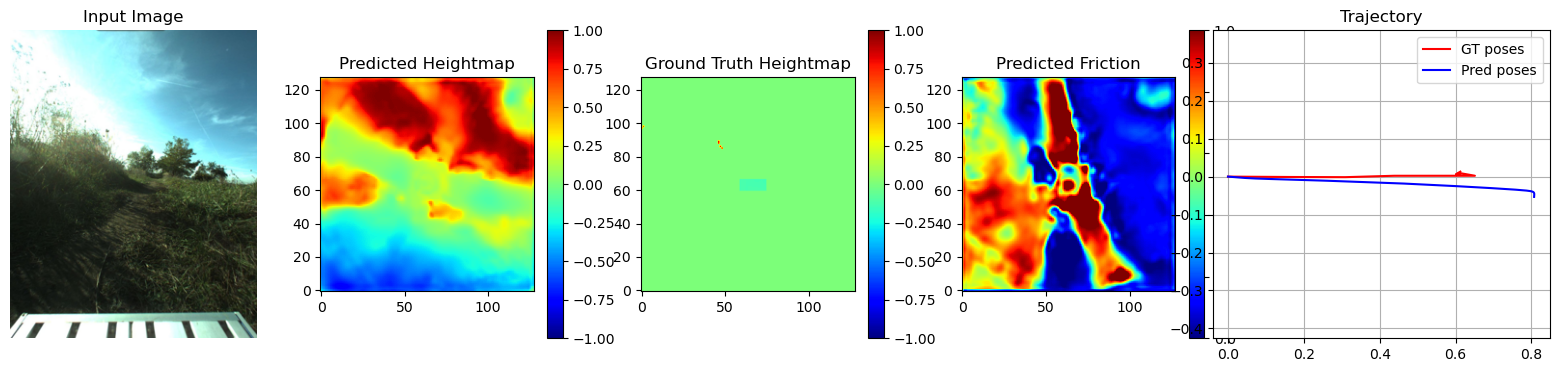

100%|██████████| 2/2 [00:08<00:00,  4.46s/it]


Train epoch: 1 Mean loss: 0.0061078008729964495
Validation sample Loss: 0.007931672967970371


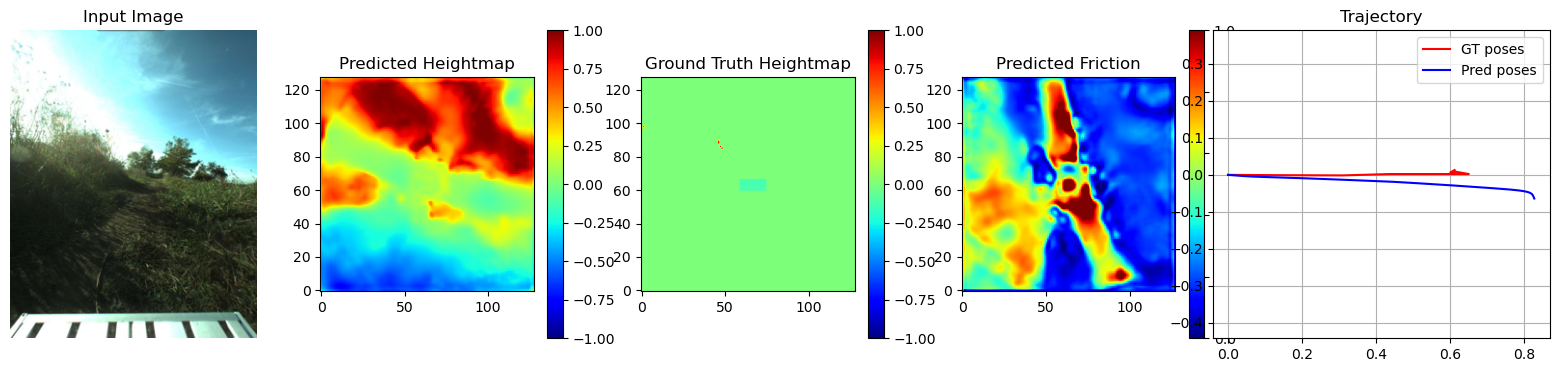

100%|██████████| 2/2 [00:08<00:00,  4.50s/it]


Train epoch: 2 Mean loss: 0.00602827500551939
Validation sample Loss: 0.007978245615959167


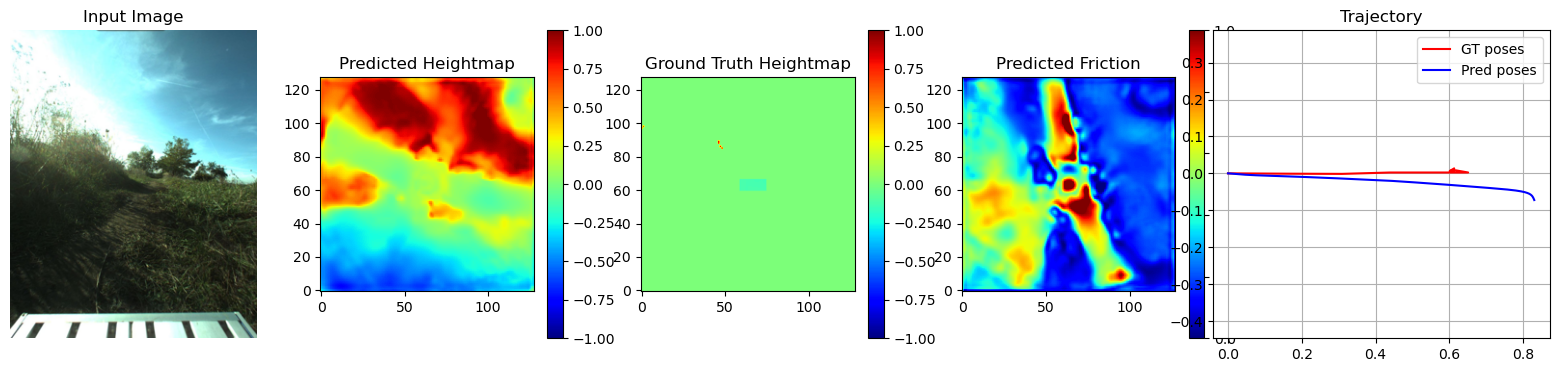

 50%|█████     | 1/2 [00:09<00:09,  9.23s/it]


KeyboardInterrupt: 

In [11]:
%matplotlib inline
from monoforce.models.terrain_encoder.utils import denormalize_img

# Training: Friction Head
# https://discuss.pytorch.org/t/how-to-train-a-part-of-a-network/8923/2
for p in lss.parameters():
    p.requires_grad = False
for p in lss.bevencode.up_friction.parameters():
    p.requires_grad = True
optimizer = torch.optim.Adam(lss.bevencode.up_friction.parameters(), lr=lr)

# train loop
for epoch in range(num_epochs):
    # epoch loop
    lss = lss.train()
    loss_epoch = 0
    for batch in tqdm(train_dl, total=len(train_dl)):
        batch = [b.to(device) for b in batch]
        
        # unpack batch
        (imgs, rots, trans, intrins, post_rots, post_trans,
         hm_geom, hm_terrain,
         control_ts, controls,
         traj_ts, Xs, Xds, Rs, Omegas) = batch
        # monoforce inputs
        inputs = [imgs, rots, trans, intrins, post_rots, post_trans]
        
        # forward pass
        height_terrain_pred, friction_pred, states_pred = monoforce_forward(inputs, lss, dphysics)
        
        # unpack states
        Xs_pred, Xds_pred, Rs_pred, Omegas_pred, _ = states_pred

        # find the closest timesteps in the trajectory to the ground truth timesteps
        ts_ids = torch.argmin(torch.abs(control_ts.unsqueeze(1) - traj_ts.unsqueeze(2)), dim=2)

        # compute the loss as the mean squared error between the predicted and ground truth poses
        batch_size = Xs.shape[0]
        loss = torch.nn.functional.mse_loss(Xs_pred[torch.arange(batch_size).unsqueeze(1), ts_ids], Xs)
        
        # accumulate loss
        loss_epoch += loss.item()

        # backpropagate
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # print epoch loss
    loss_epoch /= len(train_dl)
    print('Train epoch:', epoch, 'Mean loss:', loss_epoch)

    # evaluate model and visualize predictions
    if vis:
        with torch.no_grad():         
            # evaluate model
            lss = lss.eval()
            
            # validation data sample
            batch_val = next(iter(val_dl))
            batch_val = [b.to(device) for b in batch_val]
            
            # unpack batch
            (imgs, rots, trans, intrins, post_rots, post_trans,
             hm_geom, hm_terrain,
             control_ts, controls,
             traj_ts, Xs, Xds, Rs, Omegas) = batch_val
            # monoforce inputs
            inputs_val = [imgs, rots, trans, intrins, post_rots, post_trans]
            
            # forward pass
            height_terrain_pred, friction_pred, states_pred = monoforce_forward(inputs_val, lss, dphysics)
            # print('Heightmap mean:', height_pred_geom.mean().item(), 'Friction mean:', friction_pred.mean().item())
            
            # unpack states
            Xs_pred, Xds_pred, Rs_pred, Omegas_pred, _ = states_pred
            
            # find the closest timesteps in the trajectory to the ground truth timesteps
            ts_ids = torch.argmin(torch.abs(control_ts.unsqueeze(1) - traj_ts.unsqueeze(2)), dim=2)
    
            # compute the loss as the mean squared error between the predicted and ground truth poses
            batch_size = Xs.shape[0]
            loss_val = torch.nn.functional.mse_loss(Xs_pred[torch.arange(batch_size).unsqueeze(1), ts_ids], Xs)
            print('Validation sample Loss:', loss_val.item())
            
            # visualize
            plt.figure(figsize=(20, 4))
            plt.subplot(1, 5, 1)
            plt.imshow(denormalize_img(imgs[0, 0]))
            plt.title('Input Image')
            plt.axis('off')
            
            plt.subplot(1, 5, 2)
            plt.imshow(height_terrain_pred[0, 0].cpu().numpy().T,  origin='lower', vmin=-1, vmax=1, cmap='jet')
            plt.colorbar()
            plt.title('Predicted Heightmap')
    
            plt.subplot(1, 5, 3)
            plt.imshow(hm_terrain[0, 0].cpu().numpy().T, origin='lower', vmin=-1, vmax=1, cmap='jet')
            plt.colorbar()
            plt.title('Ground Truth Heightmap')
    
            plt.subplot(1, 5, 4)
            plt.imshow(friction_pred[0, 0].cpu().numpy().T, origin='lower', vmin=0, vmax=1, cmap='jet')
            plt.colorbar()
            plt.title('Predicted Friction')
    
            plt.subplot(1, 4, 4)
            plt.plot(Xs[0, :, 0].cpu().numpy(), Xs[0, :, 1].cpu().numpy(), 'r', label='GT poses')
            plt.plot(Xs_pred[0, :, 0].cpu().numpy(), Xs_pred[0, :, 1].cpu().numpy(), 'b', label='Pred poses')
            plt.grid()
            plt.axis('equal')
            plt.legend()
            plt.title('Trajectory')
    
            plt.show()